# Credit_Risk_Analysis


In [2]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['axes.grid'] = True
plt.gray()
from matplotlib.backends.backend_pdf import PdfPages

import pandas_profiling 
import numpy as np

# __________________________ ML_Lib -__________________

from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split  

import scipy.stats as stats
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from patsy import dmatrices


import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [3]:
loan = pd.read_csv('/home/rohan/Documents/ROHAN_DA/ALABS/___STATS___ -  cls 10 onwards/class 15_Logistic_Reg/1. Logistic Case Study - Bank Loans/bankloans.csv')

# OBSERVATIONAL ANALYSIS

In [4]:
loan.shape

(850, 9)

In [5]:
loan.info() # All var. are non_null
            # default has 150 null : we dont have data for those customers 
            # this can be used as test dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [6]:
loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


### Checking for outliers _to_ Cap

In [7]:
"""address on the higher side
income on the higher side
debtinc - HS
creddebt - HS"""

loan.apply(lambda x:x.quantile([0,0.01,0.25,0.5,0.75,0.99,1]))

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0.00,20.0,1.0,0.0,0.00,13.00,0.100,0.011696,0.045584,0.0
0.01,21.0,1.0,0.0,0.00,14.49,0.900,0.030349,0.162394,0.0
0.25,29.0,1.0,3.0,3.00,24.00,5.100,0.382176,1.045942,0.0
0.50,34.0,1.0,7.0,7.00,35.00,8.700,0.885091,2.003243,0.0
0.75,41.0,2.0,13.0,12.00,55.75,13.800,1.898440,3.903001,1.0
0.99,53.0,4.0,29.0,26.51,220.51,31.565,10.285997,16.931503,1.0
1.00,56.0,5.0,33.0,34.00,446.00,41.300,20.561310,35.197500,1.0


In [9]:
##__ Custom function for outlier mapping

def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [10]:
loan.apply(var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Pandas_profiling

In [11]:
pandas_profiling.ProfileReport(loan)

Number of variables,9
Number of observations,850
Total Missing (%),2.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Imputation & Handling categorical  data

In [12]:
# The data has no categorical column so we dont have to use get_dummy 

In [13]:
## There are null values only in y(which we would be using for testing dataset).
## so we dont need imputing values with mean of column

In [9]:
loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [11]:
## its important that after capping we assign the value back to loan DF 

loan = loan.apply(lambda x:x.clip_lower(x.quantile(0.01)))
loan = loan.apply(lambda x:x.clip_upper(x.quantile(0.99)))

In [12]:
loan.apply(var_summary).T #imputtaion done

NameError: name 'var_summary' is not defined

In [13]:
# Segregating y = value & y = null

loan_exist = loan[-loan.default.isnull()]
loan_new = loan[loan.default.isnull()]

In [31]:
loan_exist.apply(var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,700.0,0.0,24393.000000,34.847143,34.000000,7.954506,63.274169,21.000000,21.000000,23.000000,25.000000,29.000000,34.000000,40.000000,46.000000,49.000000,53.000000,53.000000
ed,700.0,0.0,1201.000000,1.715714,1.000000,0.906523,0.821784,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,4.000000
employ,700.0,0.0,5864.000000,8.377143,7.000000,6.620992,43.837531,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,18.000000,21.050000,27.010000,29.000000
address,700.0,0.0,5772.820700,8.246887,7.000000,6.728577,45.273751,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,18.000000,22.000000,26.002601,26.260100
income,700.0,0.0,31602.000000,45.145714,34.000000,33.413818,1116.483255,14.739900,15.000000,17.000000,19.000000,24.000000,34.000000,55.000000,82.000000,113.000000,190.300000,220.260100
debtinc,700.0,0.0,7158.540900,10.226487,8.600000,6.695602,44.831083,0.900000,0.900000,1.900000,2.900000,5.000000,8.600000,14.125000,19.610000,23.800000,30.701000,31.190150
creddebt,700.0,0.0,1050.549567,1.500785,0.854869,1.797644,3.231525,0.030419,0.030419,0.107029,0.170020,0.369059,0.854869,1.901955,3.621504,5.098264,9.878688,10.085393
othdebt,700.0,0.0,2116.062478,3.022946,1.987567,3.095699,9.583355,0.163114,0.163114,0.376727,0.562232,1.044178,1.987567,3.923065,7.036180,9.501648,16.802448,16.802448
default,700.0,0.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
loan_exist.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3.0,17.0,12.0,176.0,9.3,10.085393,5.008608,1.0
1,27.0,1.0,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1.0,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1.0,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2.0,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0


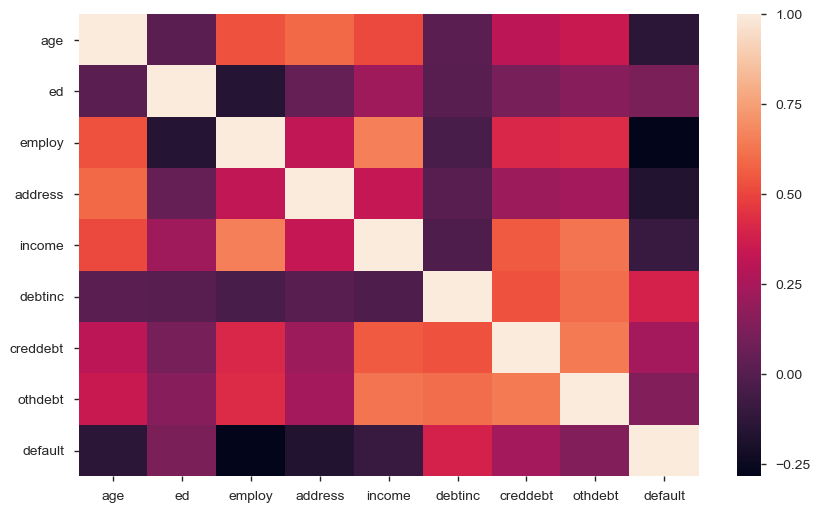

In [33]:
## Checking correlation bw variables
plt.figure(figsize=(10,6))
sns.heatmap(loan_exist.corr())

In [34]:
loan_exist.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3.0,17.0,12.0,176.0,9.3,10.085393,5.008608,1.0
1,27.0,1.0,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1.0,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1.0,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2.0,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0


### Exploratory data_analysis

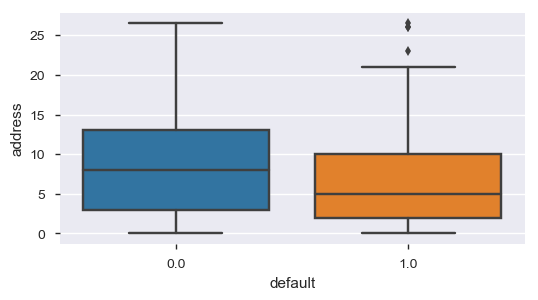

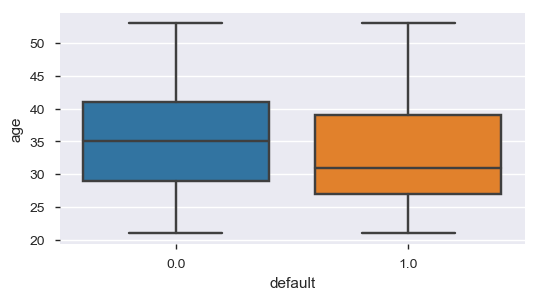

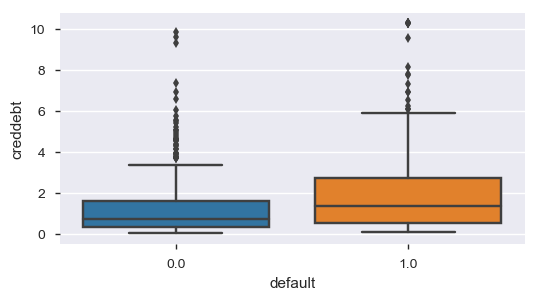

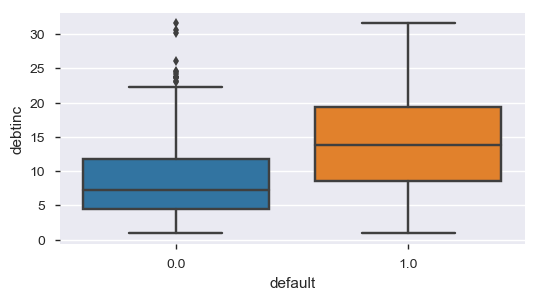

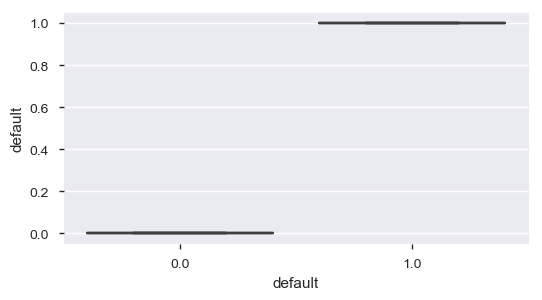

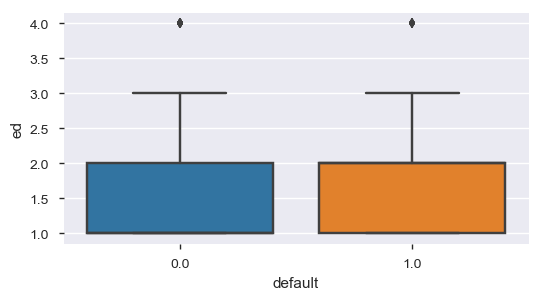

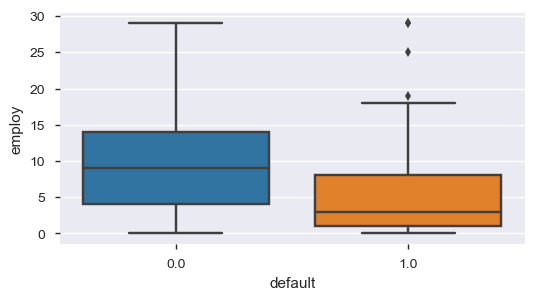

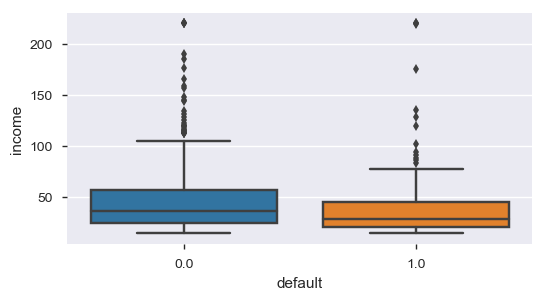

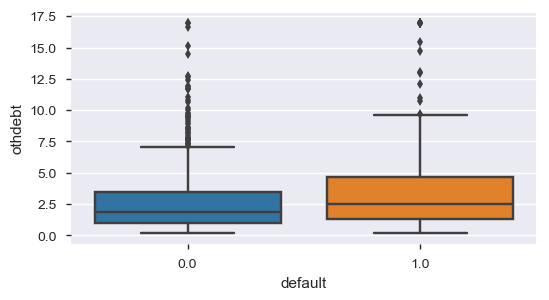

In [20]:
for a in loan_exist.columns.difference(loan_exist.default):
    fig,axes = plt.subplots(figsize=(6,3))
    sns.boxplot(y = a,x = 'default',data = loan_exist)

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)

In [15]:
# for num_variable in loan_exist.columns:
#     print(loan_exist[loan_exist['default']==1][num_variable])

#___________ 1 iteration for the below code ______________

tstats = stats.ttest_ind(loan_exist[loan_exist['default']==1]['age'],loan_exist[loan_exist['default']==0]['age'])    
tstats

temp = pd.DataFrame(['age', tstats[0], tstats[1]]).T
temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']

temp

,Variable Name,T-Statistic,P-Value
0,age,-3.69917,0.000233312


In [36]:
## Numerical Variable

## we create an empty DF
tstats_df = pd.DataFrame()
for num_variable in loan_exist.columns:
    # ttest_ind compares 2 samples(sample_mean) with ho: same mean for 2 samples(here its y=0,y=1)
    # here we are comparing mean values of each var. for defaulter and non_defaulters
    tstats = stats.ttest_ind(loan_exist[loan_exist['default']==1][num_variable],loan_exist[loan_exist['default']==0][num_variable])
    
    # each var. name is passed and stored in a temp DF along with the p value,tstats for that var.
    # temp gets overwritten for each loop running and stores only the latest data.
    # at each cycle data from temp is taken and stored in tstats DF
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    
    # this is the main DF which gets populated each time temp data is stored in this
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

tstats_df

,Variable Name,T-Statistic,P-Value
0,age,-3.69917,0.000233312
1,ed,3.15351,0.00168236
2,employ,-7.8409,1.67631e-14
3,address,-4.42881,1.09967e-05
4,income,-2.43656,0.0150765
5,debtinc,11.1433,1.1752e-26
6,creddebt,6.49628,1.56506e-10
7,othdebt,3.68857,0.00024305
8,default,inf,0


### Graphical distribution for defaulter vs Non_deafulters

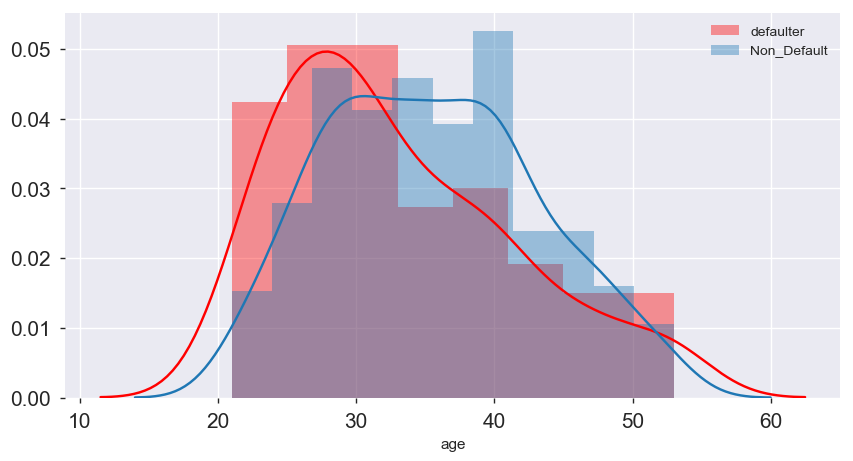

In [23]:
## This is a density plot(continous distribution histogram || on Y we have frequncy proportion(freq/total))
## same can be done for all the variables

plt.figure(figsize= (10,5))
sns.distplot(loan_exist.age[loan_exist.default ==1],color= 'red',label='defaulter')
sns.distplot(loan_exist.age[loan_exist.default ==0],label='Non_Default')


plt.tick_params(labelsize = 15)
plt.legend()

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

In [19]:
loan.shape

(850, 9)

In [24]:
loan_exist.income.head()

0    176.0
1     31.0
2     55.0
3    120.0
4     28.0
Name: income, dtype: float64

In [37]:
col = pd.concat([loan_exist.income,binned],axis=1)
col.columns = ['Income','decile']
col.sort_values('decile',ascending= False)

,Income,decile
549,86.0000,10
491,91.0000,10
343,220.0000,10
478,166.0000,10
325,120.0000,10
547,123.0000,10
6,67.0000,10
466,220.2601,10
632,136.0000,10
403,65.0000,10


## Varied_Deciling 

### Binning_Classing

In [38]:
store = pd.DataFrame()
for num_variable in loan_exist.columns.difference(['default']):
    binned = pd.cut(loan_exist[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = loan_exist.groupby(binned)['default'].sum() / (loan_exist.groupby(binned)['default'].count()-loan_exist.groupby(binned)['default'].sum())
    ser = np.log(ser)
    ## This is how we use an empty DF for filling values using a loop!
    ## This is slightly different to filling values in an empty list or Dict. 
    store = pd.concat([store,ser],axis= 1)
    store = store.rename({'default':num_variable},axis =1 )

/home/rohan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [27]:
## Baiscally this gives us the woe value for each variable
## WOE corresponds to odds ratio 
## WOE = ln(p(event)/q(non_event))
store

,address,age,creddebt,debtinc,ed,employ,income,othdebt
1,-0.675129,-0.121361,-1.447703,-2.312535,-1.310725,-0.038715,-0.806002,-1.219846
2,-0.681718,-0.735707,-0.774825,-1.757858,NaN,-0.681171,-1.182695,-1.213682
3,-0.897942,-0.824724,-0.672094,-1.406914,NaN,-1.498772,-1.372308,-0.606136
4,-1.781288,-0.949081,-0.798508,-1.029619,-0.856936,-1.462280,-1.466337,-0.955511
5,-0.810930,-1.397594,-1.223775,-0.405465,NaN,-1.403994,-3.044522,-0.470004
6,-0.897942,-1.568616,0.154151,-0.298493,NaN,-2.322388,-1.098612,-1.178655
7,-1.665008,-1.522427,0.693147,-0.080043,-0.641854,-2.335375,-inf,-1.252763
8,-2.159484,-1.673976,1.386294,0.405465,NaN,-inf,-1.098612,0.000000
9,-2.708050,-1.216395,NaN,2.079442,NaN,-1.945910,-inf,-0.693147
10,-1.945910,-0.875469,0.980829,1.299283,-0.624154,-1.252763,-0.287682,0.847298


### Binning_Classing

/home/rohan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


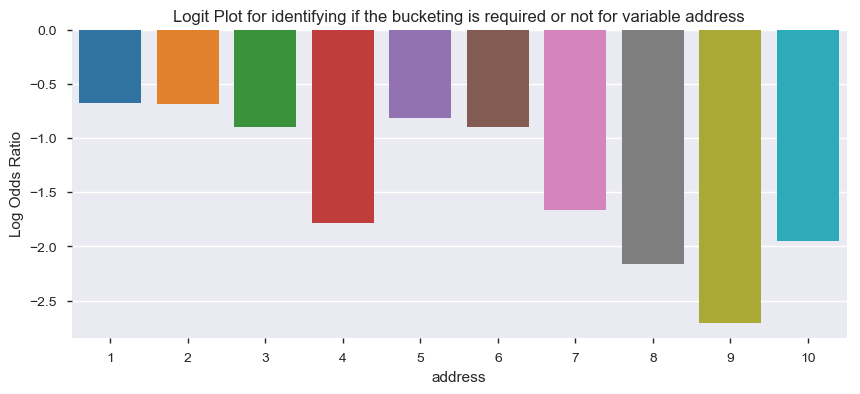

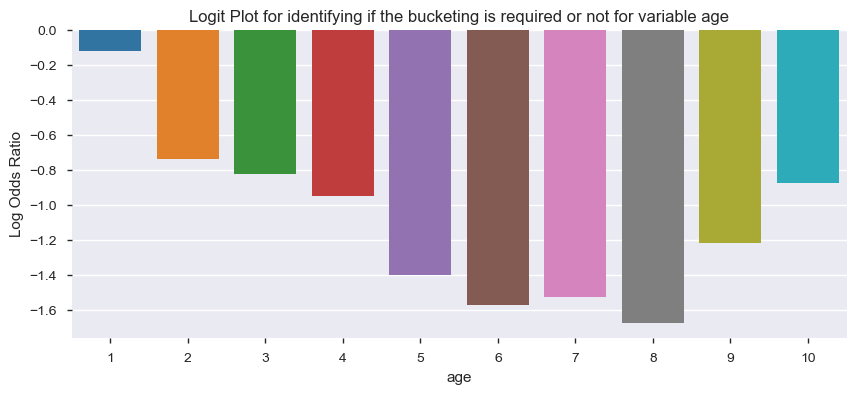

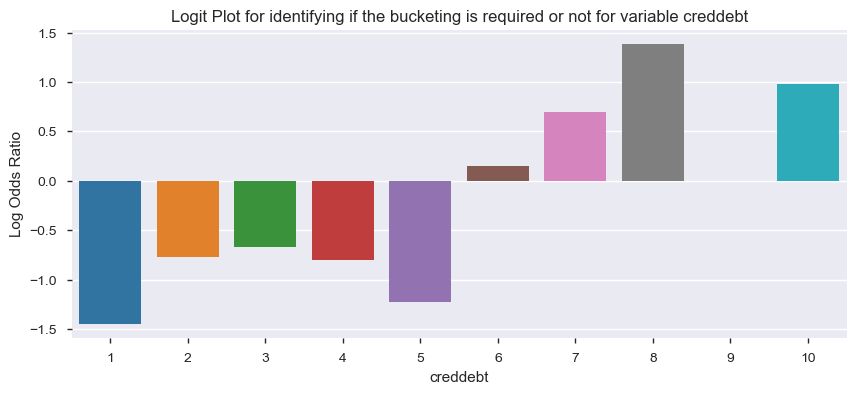

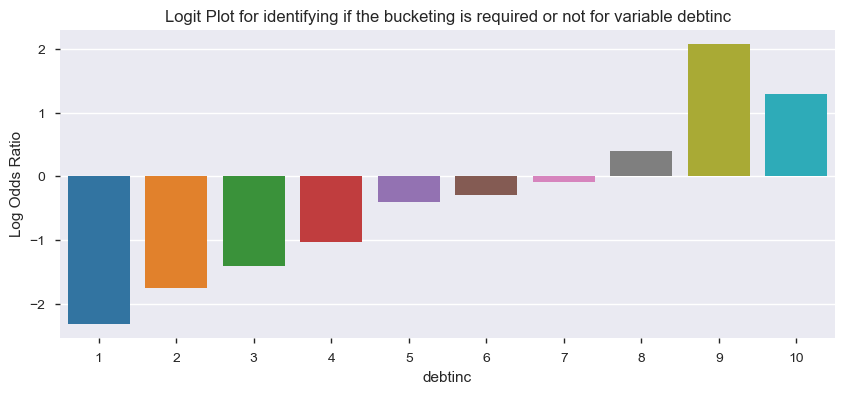

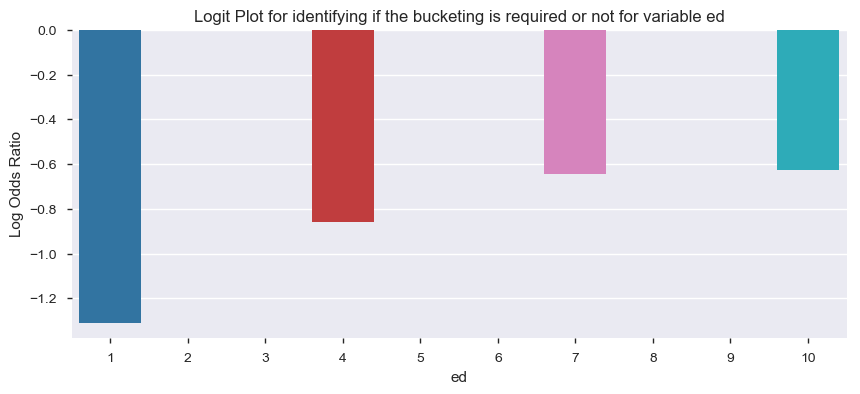

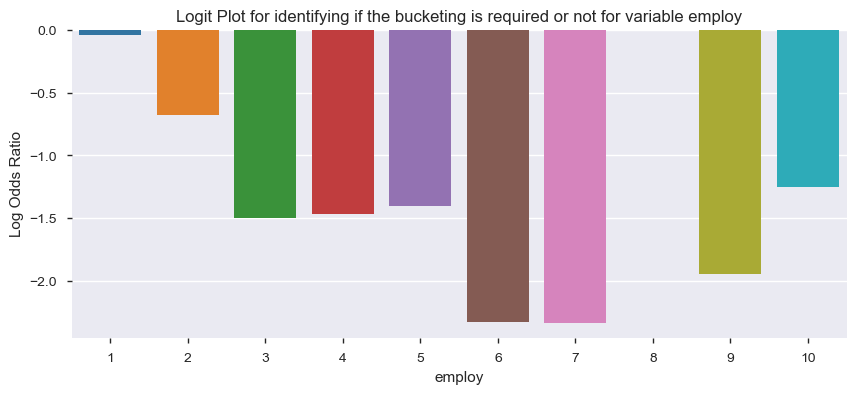

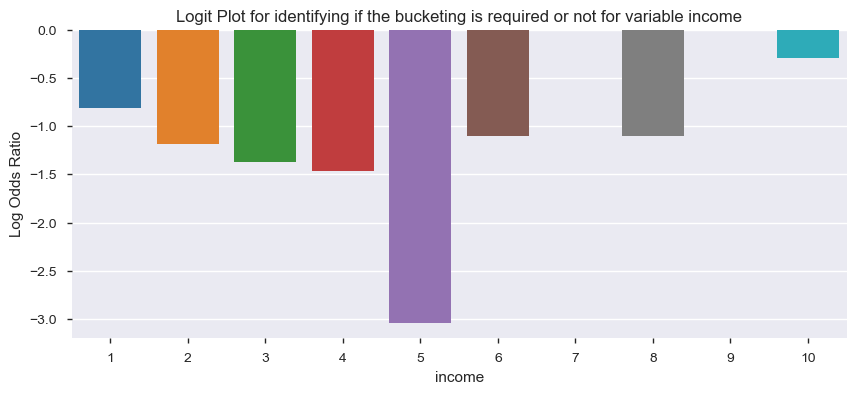

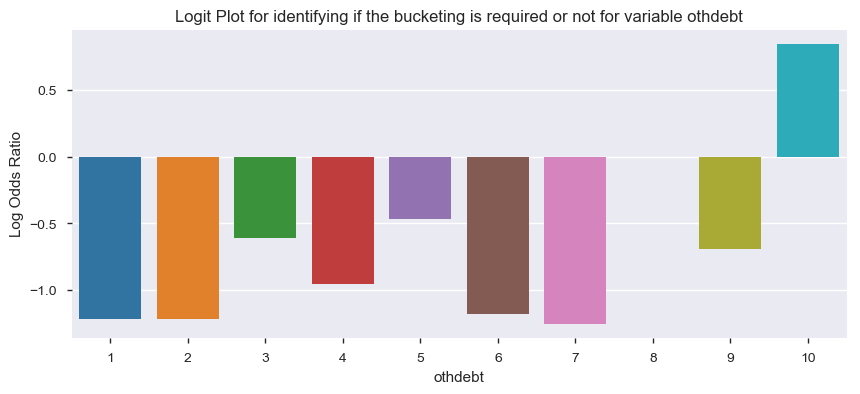

In [26]:
for num_variable in loan_exist.columns.difference(['default']):
    binned = pd.cut(loan_exist[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = loan_exist.groupby(binned)['default'].sum() / (loan_exist.groupby(binned)['default'].count()-loan_exist.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))


In [39]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
loan_exist.columns

These variables need bucketing - creddebt, othdebt, debtinc, employ, income 


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [40]:
loan_exist[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,.99,1]).T

,count,mean,std,min,0%,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,100%,max
creddebt,700.0,1.500785,1.797644,0.030419,0.030419,0.030419,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,9.878688,10.085393,10.085393
othdebt,700.0,3.022946,3.095699,0.163114,0.163114,0.163114,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,16.802448,16.802448,16.802448
debtinc,700.0,10.226487,6.695602,0.900000,0.900000,0.900000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,30.701000,31.190150,31.190150
employ,700.0,8.377143,6.620992,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,27.010000,29.000000,29.000000
income,700.0,45.145714,33.413818,14.739900,14.739900,15.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,190.300000,220.260100,220.260100


### Doubt ???

#how can we categorize creddebt on 162,221, these are pretty high scales for a ratio 
and similarly other categorizations also doesnot make much sense

In [31]:
#bucekting


#loan_exist['creddebt_extreme'] = loan_exist['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#loan_exist['othdebt_extreme'] = loan_exist['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#loan_exist['debtinc_extreme'] = loan_exist['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#loan_exist['debtinc_extreme'].value_counts()

### Variance Inflation factor

- VIF

- VIF values here indicate how much are the values inflated coz of the multicollinearlity

- The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.


1 = not correlated.

Between 1 and 5 = moderately correlated.

Greater than 5 = highly correlated.


In [42]:
## Variance Inflation Factor assessment
X = pd.concat([loan_exist[loan_exist.columns.difference(['default'])],loan_exist['default']], axis=1)
features = "+".join(loan_exist.columns.difference(['default']))
X.head()


## dmatrices basically splits the input data into train and test DF(matrices).
## Moreover the train matrix contains the intercept which is generally to be provided in statsmodel.api  
a,b = dmatrices(formula_like='default ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()

## VIF is basically trying to regress each x against all remaining x's 
vif["VIF Factor"] = [VIF(b.values, i) for i in range(b.shape[1])]

## we are storing column names as values in the dataframe 
vif["features"] = b.columns

vif

,VIF Factor,features
0,36.923978,Intercept
1,1.562808,address
2,2.034427,age
3,2.671565,creddebt
4,3.971029,debtinc
5,1.274410,ed
6,2.353757,employ
7,4.973018,income
8,4.609268,othdebt


### Model_building

In [20]:
train_X,test_X = train_test_split(loan_exist,test_size = 0.2,random_state = 42)

In [21]:
train_col_form = "+".join(train_X.columns.difference(['default']))

In [22]:
logreg =  smf.logit(formula= 'default~'+train_col_form , data = train_X)


In [24]:
result = logreg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.413926
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  560
Model:                          Logit   Df Residuals:                      551
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2019   Pseudo R-squ.:                  0.2763
Time:                        19:49:45   Log-Likelihood:                -231.80
converged:                       True   LL-Null:                       -320.28
                                        LLR p-value:                 4.457e-34
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4436      0.698     -2.069      0.039      -2.811      -0.076
address       -0.0941      0.025     -3.801      0.000      -0.143      -0.046
age            0.0313      0.019      1.641      0.101      -0.006       0.069
creddebt       0.5958      0.126      4.716      0.000       0.348       0.843
debtinc        0.0492      0.037      1.342      0.180      -0.023       0.121
ed             0.0492      0.135      0.365      0.715      -0.215       0.313
employ        -0.2573      0.037     -6.961      0.000      -0.330      -0.185
income        -0.0035      0.011     -0.320      0.749      -0.025       0.018
othdebt        0.0865      0.098      0.886      0.376      -0.105       0.278
==============================================================================
"""

## ROC_Gini

In [25]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6831574574158705
The Gini Index for the model built on the Test Data is :  0.7992776057791537


### comparing predicted values and actual values for Train & Test_dataset

In [26]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
82,0.0,0.610270
51,0.0,0.482916
220,0.0,0.022429
669,0.0,0.160233
545,0.0,0.019335


In [27]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.191020
500,0.0,0.494437
396,0.0,0.049437
155,0.0,0.286038
321,1.0,0.345593


### Confusion Matrix`

In [28]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

## Since cutoff value decides(predicts) 0/1 mapping for each probability with an actual 0/1 mapping.
## this inturn affects the TP,TN,FP,FN values and thus confusion matrix
## The agenda is to calc the specificity, etc for diff values of cutoff values
for cut_off in np.linspace(0,1,50):
    # we are creating a new column cutoff
    train_temp['cut_off'] = cut_off
    # based on cutoff we are assigning 0/1 values
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    
    ## this is a temp table storing the looped value for 3 below parameters
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    ## this is basically a repository col which stores all values stored in roc_like_table successively after each loop
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [29]:
## how train_temp looks
train_temp.head(2)

,actual,prob,cut_off,predicted,tp,fp,tn,fn
82,0.0,0.610270,1.0,0.0,0.0,0.0,1.0,0.0
51,0.0,0.482916,1.0,0.0,0.0,0.0,1.0,0.0


In [35]:
roc_like_df.head()

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.993103,0.195181
0,0.040816,0.979310,0.296386
0,0.061224,0.972414,0.356627
0,0.081633,0.958621,0.419277


### Plotting ROC_Parameters aginst different cutoffs

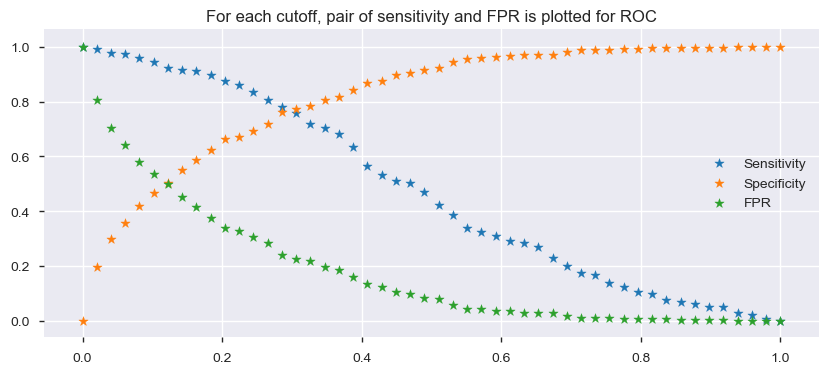

In [52]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

### Calculating the cutoff for max sensitivity + specificity

#This basically corresponds to how effective our model is in differentiating Y=0/1 against a random model with no predicting ability`

- Maximising **`sentivity + specificity`**

In [49]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.306122,0.765517,0.773494,1.539011


In [50]:
test_predict.head(2)

,actual,prob
158,1.0,0.190817
500,0.0,0.495965


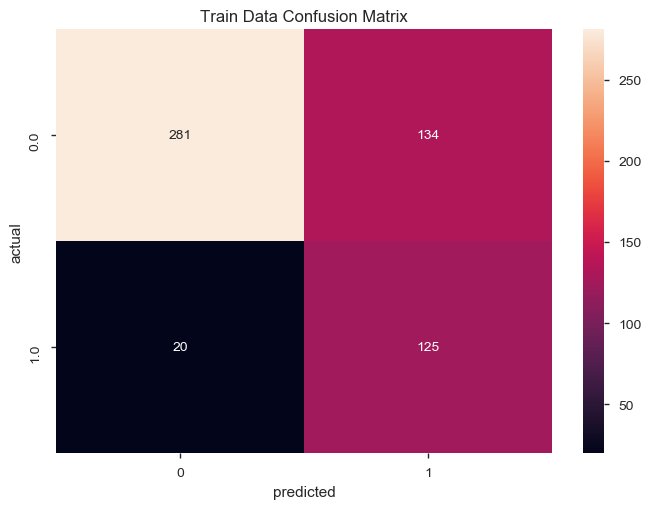

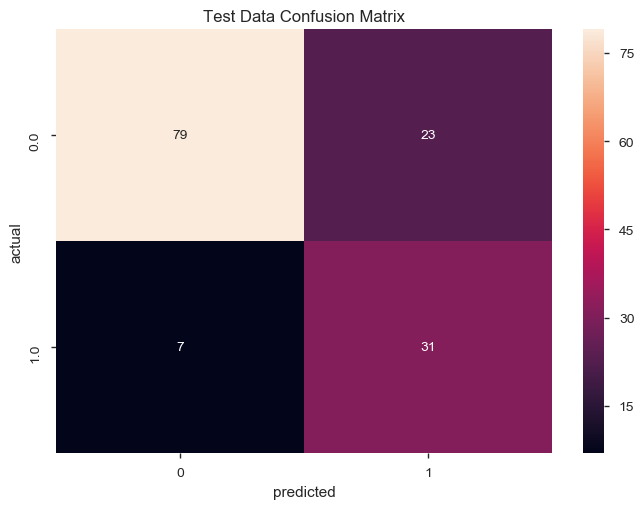

In [53]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)


sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()



sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

#### Here we are creating the same crosstab using pivottable

In [54]:
pd.pivot_table(data = train_predict[['actual','predicted','prob']],index= 'actual',columns='predicted',aggfunc='count')

prob     
predicted    0    1
actual             
0.0        281  134
1.0         20  125

In [55]:
pd.crosstab(train_predict['actual'], train_predict['predicted'])

predicted,0,1
actual,,
0.0,281,134
1.0,20,125


In [56]:
train_predict.head()

,actual,prob,predicted
82,0.0,0.610270,1
51,0.0,0.482916,1
220,0.0,0.022429,0
669,0.0,0.160233,0
545,0.0,0.019335,0


In [57]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.725
The overall accuracy score for the Test Data  is :  0.7857142857142857


## Deciling

In [58]:
## Qcut is done on 1 column(prob) and based on that we are calc. y=1/0 in each decile(which is ordered chunk 
## of 10 of prob). On the other hand, "pd.cut" takes each column once and divides into 10 and based on that
## operates on y=0/1 for calc. WOE,IV.

## Qcut used here is different to pd.cut used for classing earlier
## Qcut is just a tag which first orders data in ascending order and based on 10 equal skn of prob tags 
## each skn with values(1,10) and then in the next step we can group these.

## In pd.cut we take each column in a loop and then divide that column into 10 parts to calc woe,IV for each 
## class created for each var

In [59]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
82,0.0,0.610270,1,8
51,0.0,0.482916,1,8
220,0.0,0.022429,0,1
669,0.0,0.160233,0,4
545,0.0,0.019335,0,1


In [58]:
# Denotes how many Y=1 are there in each decile

## Y=1 should go on decreaing in a non_linear fashion as we move to lower deciles

In [68]:
train_predict.predicted.value_counts()

0    301
1    259
Name: predicted, dtype: int64

In [60]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)
df

,Deciles,actual
Deciles,,
9,504,42.0
8,448,30.0
7,392,24.0
6,336,19.0
5,280,15.0
4,224,4.0
3,168,6.0
2,112,3.0
1,56,2.0


In [57]:
train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)

,Deciles,actual
Deciles,,
9,56,56
8,56,56
7,56,56
6,56,56
5,56,56
4,56,56
3,56,56
2,56,56
1,56,56
